# HW 1 Classification

In this homework you will be building several varieties of text classifiers.

## Goal

We ask that you construct the following models in PyTorch:

1. A naive Bayes unigram classifer (follow Wang and Manning http://www.aclweb.org/anthology/P/P12/P12-2.pdf#page=118: you should only implement Naive Bayes, not the combined classifer with SVM).
2. A logistic regression model over word types (you can implement this as $y = \sigma(\sum_i W x_i + b)$) 
3. A continuous bag-of-word neural network with embeddings (similar to CBOW in Mikolov et al https://arxiv.org/pdf/1301.3781.pdf).
4. A simple convolutional neural network (any variant of CNN as described in Kim http://aclweb.org/anthology/D/D14/D14-1181.pdf).
5. Your own extensions to these models...

Consult the papers provided for hyperparameters. 


## Setup

This notebook provides a working definition of the setup of the problem itself. You may construct your models inline or use an external setup (preferred) to build your system.

In [1]:
# !pip install torchtext

In [29]:
# Text text processing library and methods for pretrained word embeddings
import torchtext
from torchtext.vocab import Vectors, GloVe
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
print(torch.__version__)

0.2.0_4


The dataset we will use of this problem is known as the Stanford Sentiment Treebank (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf). It is a variant of a standard sentiment classification task. For simplicity, we will use the most basic form. Classifying a sentence as positive or negative in sentiment. 

To start, `torchtext` requires that we define a mapping from the raw text data to featurized indices. These fields make it easy to map back and forth between readable data and math, which helps for debugging.

In [60]:
# Our input $x$
TEXT = torchtext.data.Field()

# Our labels $y$
LABEL = torchtext.data.Field(sequential=False)

In [61]:
print(TEXT)

Next we input our data. Here we will use the standard SST train split, and tell it the fields.

In [62]:
train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL,
    filter_pred=lambda ex: ex.label != 'neutral')

Let's look at this data. It's still in its original form, we can see that each example consists of a label and the original words.

In [63]:
print('len(train)', len(test))
print('vars(train[0])', vars(train[0]))

len(train) 6920
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}


In order to map this data to features, we need to assign an index to each word an label. The function build vocab allows us to do this and provides useful options that we will need in future assignments.

In [64]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)
print('len(TEXT.vocab)', len(TEXT.vocab))
print('len(LABEL.vocab)', len(LABEL.vocab), LABEL.vocab.itos)

len(TEXT.vocab) 16284
len(LABEL.vocab) 3 ['<unk>', 'positive', 'negative']


Finally we are ready to create batches of our training data that can be used for training and validating the model. This function produces 3 iterators that will let us go through the train, val and test data. 

In [65]:
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
    (train, val, test), batch_size=10, device=-1, repeat=False)

Let's look at a single batch from one of these iterators. The library automatically converts the underlying words into indices. It then produces tensors for batches of x and y. In this case it will consist of the number of words of the longest sentence (with padding) followed by the number of batches. We can use the vocabulary dictionary to convert back from these indices to words.

In [66]:
batch = next(iter(train_iter))

In [67]:
print("Size of text batch [max sent length, batch size]", batch.text.size())
print("Second in batch", batch.text[:,2])
print("Converted back to string: ", " ".join([TEXT.vocab.itos[i] for i in batch.text[:, 1].data]))

Size of text batch [max sent length, batch size] torch.Size([18, 10])
Second in batch Variable containing:
   21
   16
   17
  198
   15
  123
 2211
   20
  626
   15
   96
   34
   20
  346
    5
 1085
 3495
    2
[torch.LongTensor of size 18]

Converted back to string:  Several uninteresting , unlikeable people do bad things to and with each other in `` Unfaithful . ''


Similarly it produces a vector for each of the labels in the batch. 

In [68]:
print("Size of label batch [batch size]", batch.label.size())
print("Second in batch", batch.label[2])
print("Converted back to string: ", LABEL.vocab.itos[batch.label.data[3]])

Size of label batch [batch size] torch.Size([10])
Second in batch Variable containing:
 1
[torch.LongTensor of size 1]

Converted back to string:  negative


In [69]:
type(batch.label)

torch.autograd.variable.Variable

Finally the Vocab object can be used to map pretrained word vectors to the indices in the vocabulary. This will be very useful for part 3 and 4 of the problem.  

In [70]:
# Build the vocabulary with word embeddings
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

print(TEXT.vocab.vectors)
print("Word embeddings size ", TEXT.vocab.vectors.size())
print("Word embedding of 'follows', first 10 dim ", TEXT.vocab.vectors[TEXT.vocab.stoi['follows']][:10])

.vector_cache/wiki.simple.vec:   1%|          | 1.91M/293M [00:01<04:47, 1.01MB/s]  


KeyboardInterrupt: 

## Our models


In [13]:
#Naive Bayes
class MultinomialNB:
    def __init__(self):
        self.n_positive = 0
        self.n_negative = 0
        self.p = torch.zeros(len(TEXT.vocab))
        self.q = torch.zeros(len(TEXT.vocab))
        self.r = 0
        
    def get_features(self, case):
        f = np.zeros(len(TEXT.vocab))
        for i in case.data:
            f[i] += 1
        return torch.Tensor(f)
    
    def train(self, train_iter):
        for i in range(len(train_iter)):
            batch = next(iter(train_iter))
            if i % 100 == 0:
                print(i)
            for i in range(batch.text.size()[1]):
                fi = self.get_features(batch.text[:,i])
                if LABEL.vocab.itos[batch.label.data[i]] == "negative":
                    self.n_negative += 1
                    self.p += fi
                elif LABEL.vocab.itos[batch.label.data[i]] == "positive":
                    self.n_positive += 1
                    self.q += fi
        self.r = torch.log((self.p / self.p.sum()) / (self.q / self.q.sum()))
        
    def predict(self, batch_text):
        for k in range(batch_text.size()[1]):
            fk = self.get_features(batch.text[:,k])
            y = self.r * fk + np.log(self.n_positive / self.n_negative)
mnb = MultinomialNB()
train_iter = torchtext.data.BucketIterator(train, batch_size=10, device=-1)
mnb.train(train_iter)

0
100
200
300
400
500
600


In [14]:
print(mnb.r)


    nan
-0.1369
-0.0024
   ⋮   
    inf
    inf
    inf
[torch.FloatTensor of size 16284]



## Assignment

Now it is your turn to build the models described at the top of the assignment. 

Using the data given by this iterator, you should construct 4 different torch models that take in batch.text and produce a distribution over labels. 

When a model is trained, use the following test function to produce predictions, and then upload to the kaggle competition:  https://www.kaggle.com/c/harvard-cs281-hw1

In [15]:
def test(model):
    "All models should be able to be run with following command."
    upload = []
    # Update: for kaggle the bucket iterator needs to have batch_size 10
    test_iter = torchtext.data.BucketIterator(test, train=False, batch_size=10)
    for batch in test_iter:
        # Your prediction data here (don't cheat!)
        probs = model(b.text)
        _, argmax = probs.max(1)
        upload += list(argmax.data)

    with open("predictions.txt", "w") as f:
        for u in upload:
            f.write(str(u) + "\n")

In addition, you should put up a (short) write-up following the template provided in the repository:  https://github.com/harvard-ml-courses/cs287-s18/blob/master/template/

In [15]:
# Logistic regression; following Torch tutorial
class LogisticRegression(nn.Module):
    def __init__(self, TEXT, LABEL):
        super(LogisticRegression, self).__init__()
        # TODO: figure out what the <unk> are!!
        self.linear = nn.Linear(len(TEXT.vocab), len(LABEL.vocab))
    
    # Here bow is [N, num-features]
    def forward(self, bow):
        return F.log_softmax(self.linear(bow))

In [75]:
class TextTrainer(object):
    def __init__(self, TEXT, LABEL):
        # NLLLoss works with labels, not 1-hot encoding
        self._loss_fn = nn.NLLLoss()
        self._optimizer = optim.SGD(model.parameters(), lr=0.1)
        self._TEXT = TEXT
        self._LABEL = LABEL
        self._text_vocab_len = len(self._TEXT.vocab)
        # For review and assessment
        self._training_losses = []
        self._predictions = []
        
    def get_feature(self, batch):
        # Get bag of words one-hot feature matrix 
        size_batch = batch.text.size()[1]
        features = torch.zeros(size_batch, self._text_vocab_len)
        # TODO: find a better way to do this!
        for i in range(size_batch):
            for j in batch.text[:, i]:
                features[i, j.data[0]] += 1
        return features
    
    def get_label(self, batch):
        return batch.label.data
    
    def make_loss(self, batch):
        bow = autograd.Variable(self.get_feature(batch))
        label = autograd.Variable(self.get_label(batch))
        loss = self._loss_fn(model(bow), label)
        return loss
    
    def train(self, train_iter, model, plot=True):
        for i,batch in enumerate(train_iter):
            model.zero_grad()
            loss = self.make_loss(batch)
            
            # Get numerical value of loss, and save it
            loss_val = loss.data.numpy()[0] 
            self._training_losses.append(loss_val)
            
            if i % 100 == 0:
                print('Iteration %d, loss: %f' % (i, loss_val))
                
            # Gradient descent
            loss.backward()
            self._optimizer.step()
        if plot:
            plt.plot(np.arange(len(self._training_losses)), self._training_losses)
            plt.title("Training loss over time")
            plt.show()
            
    def predict(self, test_iter, model, predictions_file="predictions.txt",score=False):
        for i,batch in enumerate(test_iter):            
            # Generate feature vector and label
            bow = autograd.Variable(self.get_feature(batch))
            label = autograd.Variable(self.get_label(batch))
            
            # Get predictions
            probs = model(bow)
            _, argmax = probs.max(1)
            if i % 100 == 0:
                print('Iteration %d, predictions:' % (i), list(argmax.data))
            self._predictions += list(argmax.data)
            
            if predictions_file:
                with open(predictions_file, "w") as f:
                    f.write("Id,Cat\n")
                    for index,p in enumerate(self._predictions[:1821]):
                        f.write(str(index) + "," + str(p) + "\n")
        if score:
            # Open answers file and store correct values in a list
            with open("answers.txt") as f:
                content = f.readlines()
            # Ignore column names
            content = content[1:]
            answers = list(map(lambda x: int(x.split(',')[1]), content))
            print(self._predictions[:10], answers[:10])
            
            n = len(answers)
            correct = 0
            for pred,ans in zip(self._predictions[:n], answers):
                if ans == pred:
                    correct += 1
            print("Accuracy:", correct/n)


Iteration 0, loss: 1.104772
Iteration 100, loss: 0.715023
Iteration 200, loss: 0.693258
Iteration 300, loss: 0.596950
Iteration 400, loss: 0.707371
Iteration 500, loss: 0.619095
Iteration 600, loss: 0.677274


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


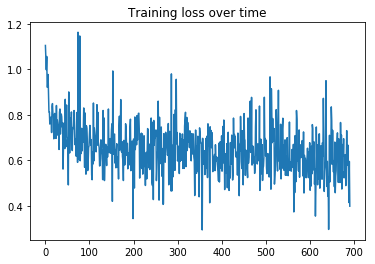

Iteration 0, predictions: [1, 2, 1, 1, 2, 1, 1, 2, 2, 2]
Iteration 100, predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


//anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:53: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


In [76]:
model = LogisticRegression(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL)
trainer.train(train_iter, model)
trainer.predict(test_iter, model)

In [24]:
model = LogisticRegression(TEXT, LABEL)
trainer = TextTrainer(TEXT, LABEL)
trainer.train(train_iter, model)

Iteration 0, loss: 1.103211
Iteration 1, loss: 0.937787
Iteration 2, loss: 0.897667
Iteration 3, loss: 0.988685
Iteration 4, loss: 0.959458
Iteration 5, loss: 0.816659
Iteration 6, loss: 0.889626
Iteration 7, loss: 0.855682
Iteration 8, loss: 0.961055
Iteration 9, loss: 0.769439


In [18]:
torch.__version__

'0.2.0_4'